In [29]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import sklearn.dummy
import sklearn.metrics
import sklearn.neural_network
import sklearn.ensemble
from joblib import dump
import seaborn as sns
import scipy
sns.set()

Fetch the data frames from the files

In [30]:
# read both the matches and the frames
trn_df = pd.read_csv('../data/processed/diff_trn.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
tst_df = pd.read_csv('../data/processed/diff_tst.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
# Reinterpret all values as int32s
trn_df = trn_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})

tst_df = tst_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})

Helper functions to format the data prior to training

In [31]:
random_state = 0
np.random.seed(random_state)
dpi = 300

def corr_filter(n):
    """ Filters the set of features based on minimum correlation n"""
    all_features = list(tuple(zip(trn_df.corr()['winner'].drop(['winner']).index.to_list(),
          trn_df.corr()['winner'].drop(['winner']).to_list())))
    drop = [i[0] for i in features if i[1] < n]
    trn_df.drop(columns=drop, inplace=True)
    tst_df.drop(columns=drop, inplace=True)
    
def plot_data(X, y):
    """Plots the data."""
    plt.scatter(*X[y==-1].T, marker="x", c="r")
    plt.scatter(*X[y==1].T, marker="x", c="b")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.gca().set_aspect('equal')
    plt.grid(False)

def plot_decision_function(model):
    """
    Plots the decision function of a model as a red-blue heatmap.
    The region evaluated, along with x and y axis limits, are determined by 'extent'.
    """
    extent = (0 , 1, 0, 1)
    x1min, x1max ,x2min, x2max = extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 200), np.linspace(x2min, x2max, 200))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    y = model.decision_function(X).reshape(x1.shape)
    plt.imshow(-y, extent=extent, origin='lower', vmin=-1, vmax=1, cmap='bwr', alpha=0.5, interpolation='nearest')
    if y.min() < 0 and y.max() > 0:
        plt.contour(x1, x2, y, levels=[0], colors=['k'])  # Decision boundary
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    plt.grid(False)
    
def plot_rf_prediction(model):
    """
    Plots the model's predictions over all points in range 2D [-3, 3].
    Assumes at most 3 classes.
    """
    extent = (0, 1, 0, 1)
    x1min, x1max ,x2min, x2max = extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    y = model.predict(X).reshape(x1.shape)
    cmap = matplotlib.colors.ListedColormap(['r', 'b', 'g'])
    plt.imshow(y, extent=extent, origin='lower', alpha=0.4, vmin=0, vmax=2, cmap=cmap, interpolation='nearest')
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    plt.gca().set_aspect('equal')
    plt.grid(False)

def scale_data(X_trn, X_tst):
    """
    Scales the data with Scikit-learn's MinMax scaler.
    """
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_tst = scaler.transform(X_tst)

    return X_trn, X_tst

def score_estimators(X, y, estimators):
    """
    Scores each estimator on (X, y), returning a list of scores.
    """
    scores = [0 for _ in range(len(estimators))]
    for x in range(len(estimators)):
        scores[x] = sklearn.metrics.accuracy_score(y, estimators[x].predict(X))
        print(sklearn.metrics.precision_recall_fscore_support(y, estimators[x].predict(X), average='binary'))
    return scores

def plot_estimator_scores(estimators, param_name, param_vals):
    """
    Plots the training, validation, and testing scores of a list of estimators,
    where `param_name` and `param_vals` are the same as for `train_estimators`.
    The estimator with best validation score will be highlighted with an 'x'.
    """
    plt.figure(dpi=dpi)
    X = np.arange(0, len(param_vals))
    trn_scores = score_estimators(X_trn, y_trn, estimators)
    tst_scores = score_estimators(X_tst, y_tst, estimators)
    index = np.argmin(trn_scores - tst_scores)
    print(tst_scores[index])
    plt.title(estimators[0].__class__.__name__ + " score vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("score")
    plt.ylim(0.0, 1.05)
    plt.scatter(X[index], tst_scores[index], marker='x', color='black', s=200)
    plt.plot(X, trn_scores, marker='o', color='green', markerfacecolor='green', label="train")
    plt.plot(X, tst_scores, marker='o', color='red', markerfacecolor='red', label="test")
    plt.text(0, 0.4,
             "Optimal Test Accuracy = %.2f%% with %s = %d " % (tst_scores[index] * 100, param_name, param_vals[index]))
    plt.legend()
    plt.xticks(X, param_vals)
    plt.grid(False)
    

def rand_param_search(X, y, estimator, param_grid, verbose=1, cv=5, n_iter=10):
    return sklearn.model_selection.RandomizedSearchCV(estimator, param_grid,verbose=verbose,
                                        cv=cv, n_iter=n_iter).fit(X, y)

def grid_param_search(X, y, estimator, param_grid, verbose=1, cv=5):
    return sklearn.model_selection.GridSearchCV(estimator, param_grid, verbose=verbose, cv=cv).fit(X, y)

Feature selection: Select an X and y we want to train on

In [50]:
# Randomly select data points for plots
indices = np.random.choice(trn_df.shape[0], 200, replace=False)
X_trn = trn_df[['kill_advantage','gold_advantage']].values
y_trn = trn_df[['winner']].values.T[0]
X_tst = tst_df[['kill_advantage','gold_advantage']].values
y_tst = tst_df[['winner']].values.T[0]
X_trn, X_tst = scale_data(X_trn, X_tst)

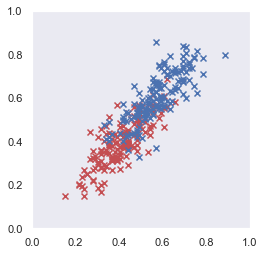

In [51]:
plot_data(X_trn[index], y_trn[index])

## Models

### AdaBoost

In [59]:
ab = sklearn.ensemble.AdaBoostClassifier(random_state=random_state)
param_grid = {
    'n_estimators' : [i for i in scipy.stats.uniform(1, 1000).rvs(10).astype('int32')],
    'algorithm' : ['SAMME', 'SAMME.R'] 
}
ab = rand_param_search(X_trn, y_trn, ab, param_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


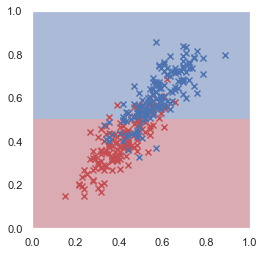

In [60]:
plot_data(X_trn[index], y_trn[index])
plot_rf_prediction(ab.best_estimator_)

## Dummy Classifier

In [44]:
def train_dummy_classifier(X, y):
    dummy_clf = sklearn.dummy.DummyClassifier(strategy='uniform', random_state=0)
    dummy_clf.fit(X, y)
    return dummy_clf


## kNN 

In [45]:
def train_kNN_estimators(X, y):
    param_grid = {
        'n_neighbors': [1, 5, 10, 15, 20]
    }
    clf = sklearn.neighbors.KNeighborsClassifier()
    gscv = train_estimators(X, y, estimator=clf, param_grid=param_grid)

    # plot_estimator_scores(knn_estimators, param_name='n_neighbors', param_vals=param_vals)
    return gscv.best_estimator_, gscv


## Random Forests

In [46]:
def train_random_forests(X, y):
    estimator = np.arange(1, 5) * 50
    depths = np.arange(1, 5) * 5
    param_grid = {
        'n_estimators': estimator, 
        'max_depth': depths
    }
    clf = sklearn.ensemble.RandomForestClassifier(random_state=0)
    gscv = train_estimators(X, y, estimator=clf, param_grid=param_grid)
    return gscv.best_estimator_, gscv

## AdaBoost

In [47]:
def train_adaboost(X, y):
    pass

## Logistic

In [48]:
def train_logistic(X, y):
    pass

## SVM

In [49]:
def train_svm(X, y):
    pass

## Neural Network

In [50]:
def train_neural_network(X, y):
    net = sklearn.neural_network.MLPClassifier(        
        learning_rate_init=0.01,
        activation='logistic',
        hidden_layer_sizes=(2,),
        momentum=0.9,
        solver='sgd',
        random_state=0,
    )
    param_grid = [
        {
            'max_iter': [5, 10, 50, 100, 150, 200]
        }
    ]
    gscv = train_estimators(X, y, estimator=net, param_grid=param_grid)
    return gscv.best_estimator_, gscv
# train_neural_network(X_trn,y_trn)

## Evaluation

In [51]:

# dm_clf = train_dummy_classifier(X_trn, y_trn)
# logistic_clf, logistic_gscv = train_logistic(X_trn, y_trn)
# boost_clf, boost_gscv = train_adaboost(X_trn, y_trn)
# svm_clf, svm_gscv = train_svm(X_trn, y_trn)
# knn_clf, knn_gscv = train_kNN_estimators(X_trn, y_trn)
# rf_clf, rf_gscv = train_random_forests(X_trn, y_trn)
# nn_clf, nn_gscv = train_neural_network(X_trn, y_trn)


Plotting each prediction

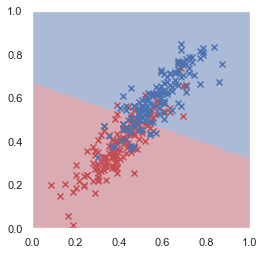

In [52]:
plt.figure()
plot_data(X_trn[:300], y_trn[:300])
plot_rf_prediction(nn_clf)

## Validation Scores

array([0.50433648, 0.67251271, 0.82187577, 0.82327876, 0.82423538,
       0.82429917])

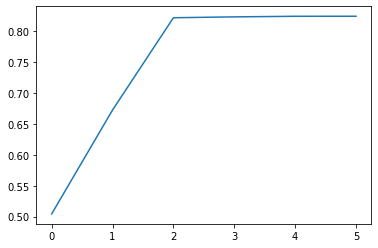

In [30]:
plt.plot(nn_gscv.cv_results_['mean_test_score'])

## Final Scores from best estimators

In [14]:
y_pred = nn_clf.predict(X_tst)
stats = sklearn.metrics.precision_recall_fscore_support(y_tst, y_pred, average='binary')
print(sklearn.metrics.accuracy_score(y_tst, y_pred))
stats

0.8237244897959184


(0.8152390438247012, 0.8364844149207972, 0.8257250945775535, None)

In [ ]:
# Dump each models for the TAs to try them out
dump(dm_clf, 'dm_clf.joblib')
dump(logistic_clf, 'logistic_clf.joblib')
dump(boost_clf, 'boost_clf.joblib')
dump(svm_clf, 'svm_clf.joblib')
dump(nn_clf, 'nn_clf.joblib')
dump(knn_clf, 'knn_clf.joblib')
dump(rf_clf, 'rf_clf.joblib')